In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [9]:
df = pd.read_csv('/content/Reviews.csv')

print("\nDataset Columns:", df.columns.tolist())

df = df[df['Score'] != 3]
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

if len(df) > 10000:
    df = df.sample(n=10000, random_state=42)

print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())


Dataset Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Sentiment Distribution:
Sentiment
1    8453
0    1547
Name: count, dtype: int64


In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

print("\nPreprocessing text...")
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)



Preprocessing text...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining model...")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)


Training model...


LogisticRegression(max_iter=1000, random_state=42)


Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.27      0.41       327
           1       0.87      0.99      0.93      1673

    accuracy                           0.88      2000
   macro avg       0.88      0.63      0.67      2000
weighted avg       0.88      0.88      0.85      2000



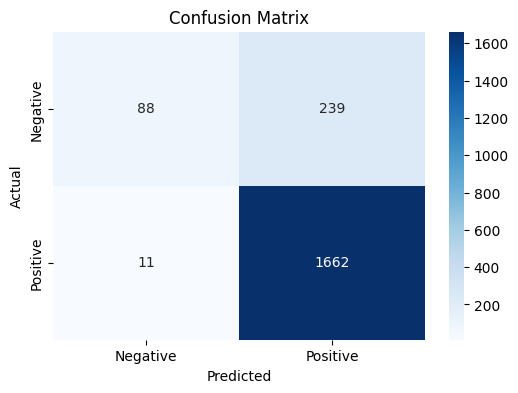

In [12]:
y_pred = logreg.predict(X_test)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
def predict_sentiment(review):
    cleaned = preprocess_text(review)
    vector = tfidf_vectorizer.transform([cleaned])
    pred = logreg.predict(vector)[0]
    proba = logreg.predict_proba(vector)[0]
    return "Positive" if pred == 1 else "Negative", max(proba)

test_reviews = [
    "This product changed my life! Worth every penny.",
    "Arrived broken and customer service ignored me.",
    "Does the job but could be better.",
    "Not bad for the price."
]

print("\nTesting Custom Reviews:")
for review in test_reviews:
    sentiment, confidence = predict_sentiment(review)
    print(f"\nReview: '{review}'\nSentiment: {sentiment} (Confidence: {confidence:.2f})")



Testing Custom Reviews:

Review: 'This product changed my life! Worth every penny.'
Sentiment: Positive (Confidence: 0.68)

Review: 'Arrived broken and customer service ignored me.'
Sentiment: Positive (Confidence: 0.76)

Review: 'Does the job but could be better.'
Sentiment: Positive (Confidence: 0.77)

Review: 'Not bad for the price.'
Sentiment: Negative (Confidence: 0.52)


In [14]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefs = logreg.coef_[0]

print("\nTop 10 Positive Words:")
print(pd.Series(coefs, index=feature_names).nlargest(10))

print("\nTop 10 Negative Words:")
print(pd.Series(coefs, index=feature_names).nsmallest(10))


Top 10 Positive Words:
great        5.574488
love         4.709858
best         4.332083
delicious    3.499737
good         3.258033
favorite     3.112836
nice         2.912964
excellent    2.894742
perfect      2.792602
wonderful    2.483333
dtype: float64

Top 10 Negative Words:
disappointed   -3.207400
worst          -2.943219
bad            -2.938507
return         -2.856222
terrible       -2.807828
stale          -2.772270
awful          -2.754533
money          -2.674307
horrible       -2.425793
waste          -2.364893
dtype: float64
